Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Generate Data

In [2]:
def generate_dogs(n):
    return np.random.uniform([2, 2], [3, 3], (n, 2))

def generate_cats(n):
    return np.random.uniform([2, -2], [3, -3], (n, 2))

def generate_gaussians(n, s):
    return np.random.normal(0, s, (n, 2))

Testing Generation

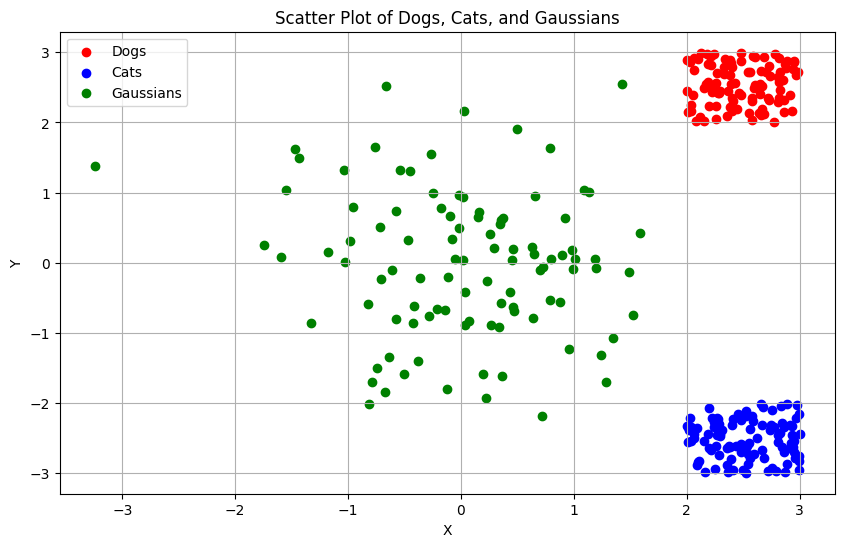

In [3]:
# Number of points to generate
n = 100

# Generate points
dogs = generate_dogs(n)
cats = generate_cats(n)
gaussians = generate_gaussians(n, 1)

# Plot points
plt.figure(figsize=(10, 6))

plt.scatter(dogs[:, 0], dogs[:, 1], c='red', label='Dogs')
plt.scatter(cats[:, 0], cats[:, 1], c='blue', label='Cats')
plt.scatter(gaussians[:, 0], gaussians[:, 1], c='green', label='Gaussians')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Dogs, Cats, and Gaussians')
plt.legend()
plt.grid(True)
plt.show()

You will need one neural network for each approach, with inputs x ∈ R^2 and t
(straight or embedded). The output is in R^2.


In [4]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 64),  # 2 for x and 1 for t
            nn.SiLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, 2)  # Output in R^2
        )
    
    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)  # Concatenate x and t
        return self.fc(xt)

Define Euler-Muryama Approach and Interpolant Approach

In [24]:
# def euler_method(x, g, dt):
#     noise = np.random.normal(size=x.shape)
#     return x + g(x) * np.sqrt(dt) * noise

def euler_method(x, score_model, t, dt, noise_scale=1.0, score_scale=1.0):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    t_tensor = torch.tensor(t, dtype=torch.float32)
    
    # Scale the score from the score model
    score = score_model(x_tensor, t_tensor).detach().numpy() * score_scale
    
    # Adjust noise variance to fit your distribution
    noise = np.random.normal(scale=noise_scale, size=x.shape)
    
    # Euler update step
    return x + score * dt + np.sqrt(dt) * noise

# Define g(x) for the Euler method
def g(x):
    return np.ones_like(x)

def interpolant(x, interpolant_net, t, dt):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(0).repeat(x_tensor.size(0), 1)  # Ensure t has the correct dimensions
    
    # Get the velocity from the interpolant network
    velocity = interpolant_net(x_tensor, t_tensor).detach().numpy()
    
    # ODE update
    return x + velocity * dt

In [27]:
# visualise the data
def plot_distributions(target, gaussians, euler_maruyama_positions):
    plt.scatter(target[:, 0], target[:, 1], label='Target', alpha=0.1, s=0.7)
    # plt.scatter(gaussians[:, 0], gaussians[:, 1], label='Gaussians', alpha=0.1, s=0.2)
    plt.scatter(euler_maruyama_positions[:, 0], euler_maruyama_positions[:, 1], label='Euler-Maruyama', c='blue', alpha=1, s=2)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_images(samples, title):
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.title(title)
    plt.grid(True)
    plt.show()
    
def plot_velocity_field(score_model, title):
    x = np.linspace(-4, 4, 20)
    y = np.linspace(-4, 4, 20)
    X, Y = np.meshgrid(x, y)
    grid = np.stack([X.flatten(), Y.flatten()], axis=1)
    t = np.zeros((grid.shape[0], 1))  # Use t=0 for visualization
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    t_tensor = torch.tensor(t, dtype=torch.float32)
    with torch.no_grad():
        velocity = score_model(grid_tensor, t_tensor).numpy()
    U = velocity[:, 0].reshape(X.shape)
    V = velocity[:, 1].reshape(X.shape)
    plt.quiver(X, Y, U, V)
    plt.title(title)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.grid(True)
    plt.show()

In [13]:
def train_score_model(model, data, targets, epochs=10000, lr=0.001, batch_size=128):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(data, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_data, batch_targets in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_data[:, :2], batch_data[:, 2:])  # Split data into x and t
            loss = criterion(outputs, batch_targets - batch_data[:, :2])  # Optimal denoiser minus xt
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss / len(dataloader)}, Learning Rate: {scheduler.get_last_lr()[0]}')
    
    return model

def train_ode_model(model, data, targets, epochs=10000, lr=0.001, batch_size=128):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(data, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_data, batch_targets in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_data[:, :2], batch_data[:, 2:])  # Split data into x and t
            
            # Calculate the loss based on the ODE dynamics
            loss = criterion(outputs, batch_targets - batch_data[:, :2])  # Target is the difference
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(dataloader)
        
        scheduler.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Train Loss: {avg_train_loss}, Learning Rate: {scheduler.get_last_lr()[0]}')

    return model

Use the score function approach to obtain an SDE that maps gaussians into
dogs. Use either f(x, t) = 0 (simple, fast, good) or the variance preserving
case (difference shown in figure slide 13). Fine to end up with any scaling s.

Epoch 0, Loss: 2.549555618315935, Learning Rate: 0.01
Epoch 1000, Loss: 0.03217687853612006, Learning Rate: 0.001
Epoch 2000, Loss: 0.010140902508283034, Learning Rate: 0.0001
Epoch 3000, Loss: 0.008068996714428067, Learning Rate: 1e-05
Epoch 4000, Loss: 0.008062606153544039, Learning Rate: 1.0000000000000002e-06


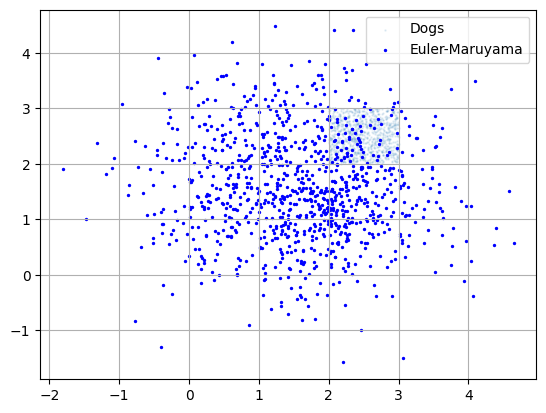

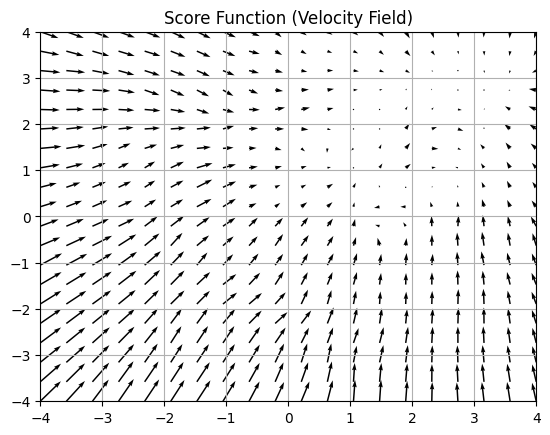

In [8]:
n = 1000

sde_dogs = generate_dogs(n)  # 2
sde_gaussians = generate_gaussians(n, s=2)  # 1

# Prepare data for training
t_steps = np.random.uniform(0, 1, (n, 1))  # Generate random time steps
data = np.hstack((sde_gaussians, t_steps))
target = sde_dogs

# Train SDE model
model = NN()
model = train_score_model(model, torch.tensor(data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32), epochs=5000, lr=0.01, batch_size=64)

# Apply Euler-Maruyama method
x_in = sde_gaussians
x_out = sde_gaussians
dt = 0.01
n_steps = 100

for step in range(n_steps):
    t = np.full((x_in.shape[0], 1), step * dt)
    # x_out = euler_method(x=x_out, g=g, dt=dt)
    x_out = euler_method(x=x_out, score_model=model, t=t, dt=dt, noise_scale=1.0, score_scale=1.0)
    # x_out = euler_method(x_out, lambda x: f(x, t, model), dt)

# Plot the results
plot_distributions(sde_dogs, sde_gaussians, x_out)

plot_velocity_field(model, 'Score Function (Velocity Field)')


Train an ODE that maps Gaussians into dogs using the linear interpolant
approach (slide 24). For this case use s = 1.


Epoch 0, Train Loss: 1.8137377426028252, Learning Rate: 0.01
Epoch 1000, Train Loss: 0.033251089858822525, Learning Rate: 0.001
Epoch 2000, Train Loss: 0.012572207429911941, Learning Rate: 0.0001
Epoch 3000, Train Loss: 0.01076761560398154, Learning Rate: 1e-05
Epoch 4000, Train Loss: 0.01063290488673374, Learning Rate: 1.0000000000000002e-06


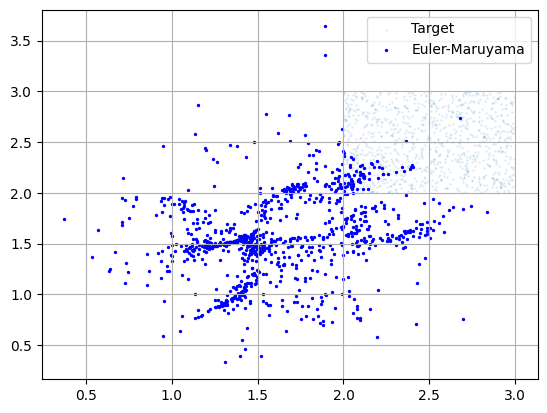

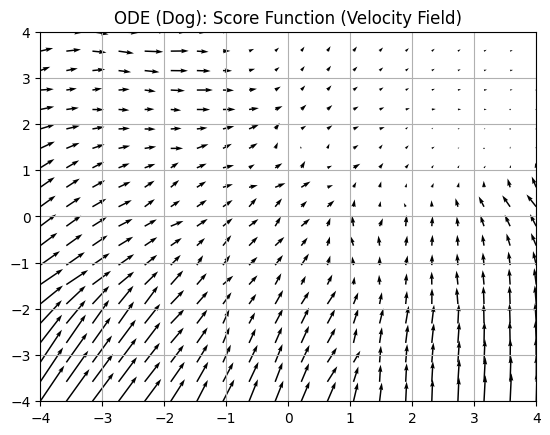

In [29]:
n = 1000

ode_dogs = generate_dogs(n)  # 2
ode_gaussians = generate_gaussians(n, s=1)  # 1

# Prepare data for training
t_steps = np.random.uniform(0, 1, (n, 1))  # Generate random time steps
data = np.hstack((ode_gaussians, t_steps))
target = ode_dogs

model = NN()
model = train_ode_model(model, torch.tensor(data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32), epochs=5000, lr=0.01, batch_size=64)

# Apply ODE method
x_in = ode_gaussians
x_out = ode_gaussians
dt = 0.01
n_steps = 100

for step in range(n_steps):
    t = np.full((x_in.shape[0], 1), step * dt)
    x_out = interpolant(x=x_out, interpolant_net=model, t=step * dt, dt=dt)


# Plot the results
plot_distributions(ode_dogs, ode_gaussians, x_out)
plot_velocity_field(model, title='ODE (Dog): Score Function (Velocity Field)')

Compare performance of the two approaches with an appropriate measure.



In [38]:
# Function to calculate MSE
def calculate_mse(real_images, generated_images):
    mse_values = F.mse_loss(real_images, generated_images, reduction='none')
    return mse_values.mean().item()

# Function to calculate SSIM
def calculate_ssim(img1, img2, window_size=11, size_average=True):
    # Create a Gaussian window
    def gaussian(window_size, sigma):
        gauss = torch.Tensor([np.exp(-(x - window_size // 2)**2 / float(2 * sigma**2)) for x in range(window_size)])
        return gauss / gauss.sum()

    def create_window(window_size, channel):
        _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    channel = img1.size(1)
    window = create_window(window_size, channel)

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean().item()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    
# Generated Samples
samples_ode = np.array(ode_gaussians)
samples_sde = np.array(sde_gaussians)
target_samples = np.array(ode_dogs)

# Calculate MSE
mse_ode = calculate_mse(torch.tensor(target_samples, dtype=torch.float32), torch.tensor(samples_ode, dtype=torch.float32))
mse_sde = calculate_mse(torch.tensor(target_samples, dtype=torch.float32), torch.tensor(samples_sde, dtype=torch.float32))

# Calculate SSIM
ssim_ode = calculate_ssim(torch.tensor(target_samples, dtype=torch.float32).unsqueeze(0).unsqueeze(0), torch.tensor(samples_ode, dtype=torch.float32).unsqueeze(0).unsqueeze(0))
ssim_sde = calculate_ssim(torch.tensor(target_samples, dtype=torch.float32).unsqueeze(0).unsqueeze(0), torch.tensor(samples_sde, dtype=torch.float32).unsqueeze(0).unsqueeze(0))

print(f'MSE for ODE Approach: {mse_ode:.3g}')
print(f'MSE for SDE Approach: {mse_sde:.3g}')
print(f'SSIM for ODE Approach: {ssim_ode:.3g}')
print(f'SSIM for SDE Approach: {ssim_sde:.3g}')

MSE for ODE Approach: 7.37
MSE for SDE Approach: 10.1
SSIM for ODE Approach: 0.0413
SSIM for SDE Approach: 0.0871


Train an ODE that maps cats into dogs using your interpolant approach.


Epoch 0, Train Loss: 1.8805843517184258, Learning Rate: 0.01


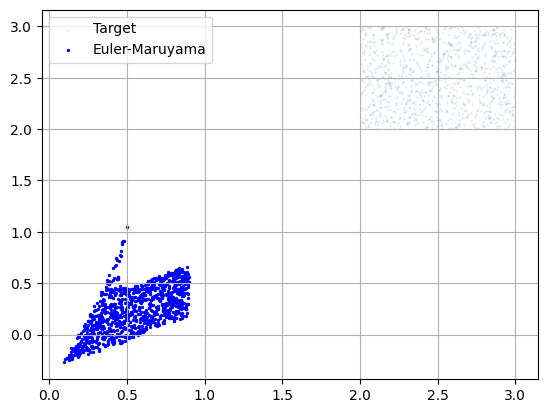

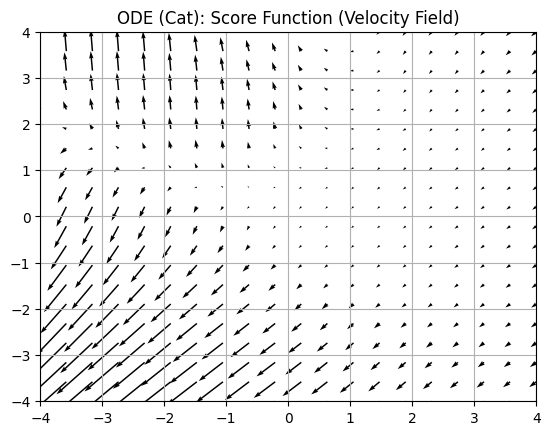

In [50]:
n = 1000

ode_dogs = generate_dogs(n)  # 2
ode_cats = generate_gaussians(n, s=1)  # 1

# Prepare data for training
t_steps = np.random.uniform(0, 1, (n, 1))  # Generate random time steps
data = np.hstack((ode_dogs, t_steps))
target = ode_cats

model = NN()
model = train_ode_model(model, torch.tensor(data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32), epochs=5000, lr=0.01, batch_size=64)

# Apply ODE method
x_in = ode_dogs
x_out = ode_dogs
dt = 0.01
n_steps = 100

for step in range(n_steps):
    t = np.full((x_in.shape[0], 1), step * dt)
    x_out = interpolant(x=x_out, interpolant_net=model, t=step * dt, dt=dt)


# Plot the results
plot_distributions(ode_dogs, ode_gaussians, x_out)
plot_velocity_field(model, title='ODE (Cat): Score Function (Velocity Field)')